# Idomatic Pandas

> Q: How do I make my pandas code faster with parallelism?

> A: You don’t need parallelism, you can use Pandas better.

> -- Matthew Rocklin

Now that we have been exposed to the basic functionality of pandas, lets explore some more advanced features that will be useful when addressing more complex data management tasks.

As most statisticians/data analysts will admit, often the lion's share of the time spent implementing an analysis is devoted to preparing the data itself, rather than to coding or running a particular model that uses the data. This is where Pandas and  Python's standard library are beneficial, providing high-level, flexible, and efficient tools for manipulating your data as needed.

As you may already have noticed, there are sometimes mutliple ways to achieve the same goal using pandas. Importantly, some approaches are better than others, in terms of performance, readability and ease of use. We will cover some important ways of maximizing your pandas efficiency.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reshaping DataFrame objects

In the context of a single DataFrame, we are often interested in re-arranging the layout of our data. 

This dataset in from Table 6.9 of [Statistical Methods for the Analysis of Repeated Measurements](http://www.amazon.com/Statistical-Methods-Analysis-Repeated-Measurements/dp/0387953701) by Charles S. Davis, pp. 161-163 (Springer, 2002). These data are from a multicenter, randomized controlled trial of botulinum toxin type B (BotB) in patients with cervical dystonia (spasmodic torticollis) from nine U.S. sites.

* Randomized to placebo (N=36), 5000 units of BotB (N=36), 10,000 units of BotB (N=37)
* Response variable: total score on Toronto Western Spasmodic Torticollis Rating Scale (TWSTRS), measuring severity, pain, and disability of cervical dystonia (high scores mean more impairment)
* TWSTRS measured at baseline (week 0) and weeks 2, 4, 8, 12, 16 after treatment began

In [3]:
cdystonia = pd.read_csv("../data/cdystonia.csv", index_col=None)
cdystonia.head()

,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24
3,1,4,8,1,1,5000U,65,F,37
4,1,5,12,1,1,5000U,65,F,39


This dataset includes **repeated measurements** of the same individuals (longitudinal data). Its possible to present such information in (at least) two ways: showing each repeated measurement in their own row, or in multiple columns representing multiple measurements.


The `stack` method **rotates** the data frame so that columns are represented in rows:

In [4]:
stacked = cdystonia.stack()
stacked

0    patient        1
     obs            1
     week           0
     site           1
     id             1
     treat      5000U
     age           65
     sex            F
     twstrs        32
1    patient        1
     obs            2
     week           2
     site           1
     id             1
     treat      5000U
     age           65
     sex            F
     twstrs        30
2    patient        1
     obs            3
     week           4
     site           1
     id             1
     treat      5000U
     age           65
     sex            F
     twstrs        24
3    patient        1
     obs            4
     week           8
                ...  
627  age           57
     sex            M
     twstrs        38
628  patient      109
     obs            4
     week           8
     site           9
     id            11
     treat      5000U
     age           57
     sex            M
     twstrs        33
629  patient      109
     obs            5
     week 

Have a peek at the structure of the index of the stacked data (and the data itself).

To complement this, `unstack` pivots from rows back to columns.

In [5]:
stacked.unstack().head()

,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24
3,1,4,8,1,1,5000U,65,F,37
4,1,5,12,1,1,5000U,65,F,39


## Exercise

Which columns uniquely define a row? Create a DataFrame called `cdystonia2` with a hierarchical index based on these columns.

In [6]:
# Write your answer here

If we want to transform this data so that repeated measurements are in columns, we can `unstack` the `twstrs` measurements according to `obs`.

In [12]:
cdystonia2 = cdystonia.set_index(['patient', 'obs'])

In [13]:
twstrs_wide = cdystonia2['twstrs'].unstack('obs')
twstrs_wide.head()

obs,1,2,3,4,5,6
patient,,,,,,
1,32.0,30.0,24.0,37.0,39.0,36.0
2,60.0,26.0,27.0,41.0,65.0,67.0
3,44.0,20.0,23.0,26.0,35.0,35.0
4,53.0,61.0,64.0,62.0,NaN,NaN
5,53.0,35.0,48.0,49.0,41.0,51.0


We can now **merge** these reshaped outcomes data with the other variables to create a **wide format** DataFrame that consists of one row for each patient.

In [39]:
cdystonia_wide = (cdystonia[['patient','site','id','treat','age','sex']]
                  .drop_duplicates()
                  .merge(twstrs_wide, right_index=True, left_on='patient', how='inner'))
cdystonia_wide.head()

,patient,site,id,treat,age,sex,1,2,3,4,5,6
0,1,1,1,5000U,65,F,32.0,30.0,24.0,37.0,39.0,36.0
6,2,1,2,10000U,70,F,60.0,26.0,27.0,41.0,65.0,67.0
12,3,1,3,5000U,64,F,44.0,20.0,23.0,26.0,35.0,35.0
18,4,1,4,Placebo,59,F,53.0,61.0,64.0,62.0,NaN,NaN
22,5,1,5,10000U,76,F,53.0,35.0,48.0,49.0,41.0,51.0


A slightly cleaner way of doing this is to set the patient-level information as an index before unstacking:

In [15]:
(cdystonia.set_index(['patient','site','id','treat','age','sex','week'])['twstrs']
     .unstack('week').head())

,,,,,week,0,2,4,8,12,16
patient,site,id,treat,age,sex,,,,,,
1,1,1,5000U,65,F,32.0,30.0,24.0,37.0,39.0,36.0
2,1,2,10000U,70,F,60.0,26.0,27.0,41.0,65.0,67.0
3,1,3,5000U,64,F,44.0,20.0,23.0,26.0,35.0,35.0
4,1,4,Placebo,59,F,53.0,61.0,64.0,62.0,NaN,NaN
5,1,5,10000U,76,F,53.0,35.0,48.0,49.0,41.0,51.0


To convert our "wide" format back to long, we can use the `melt` function, appropriately parameterized. This function is useful for `DataFrame`s where one
or more columns are identifier variables (`id_vars`), with the remaining columns being measured variables (`value_vars`). The measured variables are "unpivoted" to
the row axis, leaving just two non-identifier columns, a *variable* and its corresponding *value*, which can both be renamed using optional arguments.

In [16]:
pd.melt(cdystonia_wide, id_vars=['patient','site','id','treat','age','sex'], 
        var_name='obs', value_name='twsters').head()

,patient,site,id,treat,age,sex,obs,twsters
0,1,1,1,5000U,65,F,1,32.0
1,2,1,2,10000U,70,F,1,60.0
2,3,1,3,5000U,64,F,1,44.0
3,4,1,4,Placebo,59,F,1,53.0
4,5,1,5,10000U,76,F,1,53.0


This illustrates the two formats for longitudinal data: **long** and **wide** formats. Its typically better to store data in long format because additional data can be included as additional rows in the database, while wide format requires that the entire database schema be altered by adding columns to every row as data are collected.

The preferable format for analysis depends entirely on what is planned for the data, so it is imporant to be able to move easily between them.

## Method chaining

In the DataFrame reshaping section above, you probably noticed how several methods were strung together to produce a wide format table:

In [37]:
(cdystonia[['patient','site','id','treat','age','sex']]
                  .drop_duplicates()
                  .merge(twstrs_wide, right_index=True, left_on='patient', how='inner')
                  .head())

This approach of seqentially calling methods is called **method chaining**, and despite the fact that it creates very long lines of code that must be properly justified, it allows for the writing of rather concise and readable code. Method chaining is possible because of the pandas convention of returning copies of the results of operations, rather than in-place operations. This allows methods from the returned object to be immediately called, as needed, rather than assigning the output to a variable that might not otherwise be used. For example, without method chaining we would have done the following:

In [40]:
cdystonia_subset = cdystonia[['patient','site','id','treat','age','sex']]
cdystonia_complete = cdystonia_subset.drop_duplicates()
cdystonia_merged = cdystonia_complete.merge(twstrs_wide, right_index=True, left_on='patient', how='inner')
cdystonia_merged.head()

,patient,site,id,treat,age,sex,1,2,3,4,5,6
0,1,1,1,5000U,65,F,32.0,30.0,24.0,37.0,39.0,36.0
6,2,1,2,10000U,70,F,60.0,26.0,27.0,41.0,65.0,67.0
12,3,1,3,5000U,64,F,44.0,20.0,23.0,26.0,35.0,35.0
18,4,1,4,Placebo,59,F,53.0,61.0,64.0,62.0,NaN,NaN
22,5,1,5,10000U,76,F,53.0,35.0,48.0,49.0,41.0,51.0


This necessitates the creation of a slew of intermediate variables that we really don't need.

Let's transform another dataset using method chaining. The `measles.csv` file contains de-identified cases of measles from an outbreak in Sao Paulo, Brazil in 1997. The file contains rows of individual records:

In [41]:
measles = pd.read_csv("../data/measles.csv", index_col=0, encoding='latin-1', parse_dates=['ONSET'])
measles.head()

,TYPE,SEX,DISTRICT,COUNTY,MONTH,YEAR,WEEK,ONSET,CONCLUSION,BIRTH YEAR,YEAR_AGE
0,Y,M,NaN,POA,1.0,97,1.0,1997-01-02,CONFIRMED,1973.0,24.0
1,Y,M,NaN,TATUI,1.0,97,2.0,1997-01-09,CONFIRMED,1991.0,6.0
2,Y,F,NaN,GUARULHOS,1.0,97,2.0,1997-01-10,CONFIRMED,1973.0,24.0
3,Y,F,NaN,GUARULHOS,1.0,97,2.0,1997-01-12,CONFIRMED,1976.0,21.0
4,Y,F,NaN,POA,1.0,97,2.0,1997-01-12,CONFIRMED,1976.0,21.0


The goal is to summarize this data by age groups and bi-weekly period, so that we can see how the outbreak affected different ages over the course of the outbreak.

The best approach is to build up the chain incrementally. We can begin by generating the age groups (using `cut`) and grouping by age group and the date (`ONSET`):

In [55]:
(measles.assign(AGE_GROUP=pd.cut(measles.YEAR_AGE, [0,5,10,15,20,25,30,35,40,100], right=False))
                        .groupby(['ONSET', 'AGE_GROUP']))

What we then want is the number of occurences in each combination, which we can obtain by checking the `size` of each grouping:

In [59]:
(measles.assign(AGE_GROUP=pd.cut(measles.YEAR_AGE, [0,5,10,15,20,25,30,35,40,100], right=False))
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()).head(10)

ONSET       AGE_GROUP
1997-01-01  [0, 5)       2
1997-01-02  [0, 5)       3
            [5, 10)      2
            [20, 25)     1
1997-01-03  [0, 5)       2
1997-01-05  [10, 15)     1
1997-01-06  [0, 5)       1
1997-01-07  [0, 5)       6
            [5, 10)      1
            [15, 20)     1
dtype: int64

This results in a hierarchically-indexed `Series`, which we can pivot into a `DataFrame` by simply unstacking:

In [62]:
(measles.assign(AGE_GROUP=pd.cut(measles.YEAR_AGE, [0,5,10,15,20,25,30,35,40,100], right=False))
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()).head(5)

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-01,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-02,3.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1997-01-03,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-05,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-06,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, fill replace the missing values with zeros:

In [63]:
(measles.assign(AGE_GROUP=pd.cut(measles.YEAR_AGE, [0,5,10,15,20,25,30,35,40,100], right=False))
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .fillna(0)).head(5)

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-01,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997-01-02,3.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1997-01-03,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997-01-05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1997-01-06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, we want the counts in 2-week intervals, rather than as irregularly-reported days, which yields our the table of interest:

In [65]:
case_counts_2w = (measles.assign(AGE_GROUP=pd.cut(measles.YEAR_AGE, [0,5,10,15,20,25,30,35,40,100], right=False))
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .fillna(0)
                        .resample('2W')
                        .sum())

case_counts_2w

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,7.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1997-01-19,54.0,8.0,1.0,4.0,4.0,8.0,4.0,1.0,0.0
1997-02-02,46.0,8.0,3.0,3.0,3.0,5.0,1.0,0.0,2.0
1997-02-16,41.0,3.0,3.0,3.0,9.0,5.0,3.0,0.0,2.0
1997-03-02,67.0,14.0,4.0,8.0,11.0,8.0,6.0,1.0,3.0
1997-03-16,103.0,32.0,9.0,21.0,28.0,20.0,11.0,2.0,4.0
1997-03-30,97.0,23.0,13.0,15.0,15.0,14.0,6.0,3.0,4.0
1997-04-13,96.0,23.0,11.0,12.0,22.0,19.0,8.0,4.0,2.0
1997-04-27,105.0,24.0,18.0,19.0,40.0,23.0,12.0,4.0,3.0


From this, it is easy to create meaningful plots and conduct analyses:

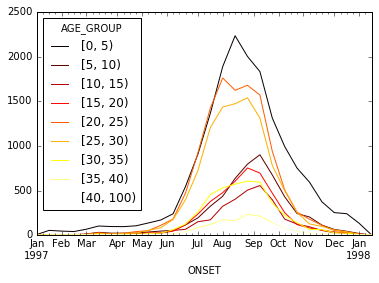

In [54]:
case_counts_2w.plot(cmap='hot')

## Pivoting

The `pivot` method allows a DataFrame to be transformed easily between long and wide formats in the same way as a pivot table is created in a spreadsheet. It takes three arguments: `index`, `columns` and `values`, corresponding to the DataFrame index (the row headers), columns and cell values, respectively.

For example, we may want the `twstrs` variable (the response variable) in wide format according to patient, as we saw with the unstacking method above:

In [11]:
cdystonia.pivot(index='patient', columns='obs', values='twstrs').head()

obs,1,2,3,4,5,6
patient,,,,,,
1,32.0,30.0,24.0,37.0,39.0,36.0
2,60.0,26.0,27.0,41.0,65.0,67.0
3,44.0,20.0,23.0,26.0,35.0,35.0
4,53.0,61.0,64.0,62.0,NaN,NaN
5,53.0,35.0,48.0,49.0,41.0,51.0


### Exercise

Try pivoting the `cdystonia` DataFrame without specifying a variable for the cell values:

In [12]:
# Write your answer here

A related method, `pivot_table`, creates a spreadsheet-like table with a hierarchical index, and allows the values of the table to be populated using an arbitrary **aggregation function**.

In [13]:
cdystonia.pivot_table(index=['site', 'treat'], columns='week', values='twstrs', 
                      aggfunc=max).head(20)

week          0   2   4   8   12  16
site treat                          
1    10000U   60  41  48  49  65  67
     5000U    44  32  34  43  42  46
     Placebo  53  61  64  62  32  38
2    10000U   65  60  60  64  67  66
     5000U    67  64  65  64  62  64
     Placebo  53  56  52  57  61  54
3    10000U   50  43  51  46  49  56
     5000U    52  44  47  50  50  49
     Placebo  43  38  40  48  49  44
4    10000U   54  52  52  54  51  57
     5000U    52  34  43  45  47  46
     Placebo  52  55  51  52  54  57
5    10000U   50  50  32  46  54  57
     5000U    60  53  55  62  67  26
     Placebo  60  57  53  52  53  58
6    10000U   55  56  47  53  51  51
     5000U    59  55  50  56  59  53
     Placebo  54  53  51  57  57  57
7    10000U   53  47  45  45  50  53
     5000U    53  45  52  51  52  53

For a simple **cross-tabulation** of group frequencies, the `crosstab` function (not a method) aggregates counts of data according to factors in rows and columns. The factors may be hierarchical if desired.

In [14]:
pd.crosstab(cdystonia.sex, cdystonia.site)

site,1,2,3,4,5,6,7,8,9
sex,,,,,,,,,
F,52,53,42,30,22,54,66,48,28
M,18,29,30,18,11,33,6,58,33


## Data transformation

There are a slew of additional operations for DataFrames that we would collectively refer to as **transformations** which include tasks such as:

- removing duplicate values
- replacing values
- grouping values.

### Dealing with duplicates

We can easily identify and remove duplicate values from `DataFrame` objects. For example, say we want to remove ships from our `vessels` dataset that have the same name:

In [15]:
vessels = pd.read_csv('../data/AIS/vessel_information.csv')
vessels.tail(10)

,mmsi,num_names,names,sov,flag,flag_type,num_loas,loa,max_loa,num_types,type
10761,857632392,1,Ct Pilot,N,Unknown,Unknown,1,20.0,20.0,1,Diving
10762,866946820,1,Catherine Turecamo,N,Unknown,Unknown,2,0.0/33.0,33.0,1,Tug
10763,888888882,1,Thomas,N,Unknown,Unknown,1,65.0,65.0,2,Towing/Tug
10764,888888888,1,Earl Jones,N,Unknown,Unknown,1,40.0,40.0,1,Towing
10765,900000000,3,Capt.webster Pc/Elk River/Roger Binsfeld,N,Unknown,Unknown,3,22.0/38.0/351.0,351.0,3,Fishing/Reserved/Towing
10766,919191919,1,Oi,N,Unknown,Unknown,1,20.0,20.0,1,Pleasure
10767,967191190,1,Pathfinder,N,Unknown,Unknown,1,31.0,31.0,2,BigTow/Towing
10768,975318642,1,Island Express,N,Unknown,Unknown,1,20.0,20.0,1,Towing
10769,987654321,2,Island Lookout/Island Tide,N,Unknown,Unknown,2,22.0/23.0,23.0,2,Fishing/Towing
10770,999999999,1,Triple Attraction,N,Unknown,Unknown,1,30.0,30.0,1,Pleasure


In [16]:
vessels.duplicated(subset='names').tail(10)

10761    False
10762     True
10763     True
10764    False
10765    False
10766    False
10767     True
10768     True
10769    False
10770     True
dtype: bool

These rows can be removed using `drop_duplicates`

In [17]:
vessels.drop_duplicates(['names']).tail(10)

,mmsi,num_names,names,sov,flag,flag_type,num_loas,loa,max_loa,num_types,type
10756,735057548,1,Chimborazo,N,Ecuador,Foreign,1,228.0,228.0,1,Tanker
10757,735059037,1,B.e Guayas,N,Ecuador,Foreign,2,44.0/78.0,78.0,1,Sailing
10758,760101000,1,Yacu Puma,N,Peru,Foreign,2,142.0/148.0,148.0,1,Cargo
10759,770576100,1,Capitan Miranda,N,Uruguay (Eastern Republic of),Foreign,1,60.0,60.0,1,Sailing
10760,812719000,1,Ocean Trader,N,Unknown,Unknown,1,52.0,52.0,1,Tanker
10761,857632392,1,Ct Pilot,N,Unknown,Unknown,1,20.0,20.0,1,Diving
10764,888888888,1,Earl Jones,N,Unknown,Unknown,1,40.0,40.0,1,Towing
10765,900000000,3,Capt.webster Pc/Elk River/Roger Binsfeld,N,Unknown,Unknown,3,22.0/38.0/351.0,351.0,3,Fishing/Reserved/Towing
10766,919191919,1,Oi,N,Unknown,Unknown,1,20.0,20.0,1,Pleasure
10769,987654321,2,Island Lookout/Island Tide,N,Unknown,Unknown,2,22.0/23.0,23.0,2,Fishing/Towing


### Value replacement

Frequently, we get data columns that are encoded as strings that we wish to represent numerically for the purposes of including it in a quantitative analysis. For example, consider the treatment variable in the cervical dystonia dataset:

In [18]:
cdystonia.treat.value_counts()

10000U     213
5000U      211
Placebo    207
Name: treat, dtype: int64

A logical way to specify these numerically is to change them to integer values, perhaps using "Placebo" as a baseline value. If we create a dict with the original values as keys and the replacements as values, we can pass it to the `map` method to implement the changes.

In [19]:
treatment_map = {'Placebo': 0, '5000U': 1, '10000U': 2}

In [20]:
cdystonia['treatment'] = cdystonia.treat.map(treatment_map)
cdystonia.treatment

0      1
1      1
2      1
3      1
4      1
5      1
6      2
7      2
8      2
9      2
10     2
11     2
12     1
13     1
14     1
15     1
16     1
17     1
18     0
19     0
20     0
21     0
22     2
23     2
24     2
25     2
26     2
27     2
28     2
29     2
      ..
601    2
602    2
603    2
604    0
605    0
606    0
607    0
608    0
609    0
610    1
611    1
612    1
613    1
614    1
615    1
616    2
617    2
618    2
619    2
620    2
621    2
622    2
623    2
624    2
625    2
626    1
627    1
628    1
629    1
630    1
Name: treatment, dtype: int64

Alternately, if we simply want to replace particular values in a `Series` or `DataFrame`, we can use the `replace` method. 

An example where replacement is useful is replacing sentinel values with an appropriate numeric value prior to analysis. A large negative number is sometimes used in otherwise positive-valued data to denote missing values.

In [21]:
scores = pd.Series([99, 76, 85, -999, 84, 95])

In such situations, we can use `replace` to substitute `nan` where the sentinel values occur.

In [22]:
scores.replace(-999, np.nan)

0    99.0
1    76.0
2    85.0
3     NaN
4    84.0
5    95.0
dtype: float64

We can also perform the same replacement that we used `map` for with `replace`:

In [23]:
cdystonia2.treat.replace({'Placebo': 0, '5000U': 1, '10000U': 2})

patient  obs
1        1      1
         2      1
         3      1
         4      1
         5      1
         6      1
2        1      2
         2      2
         3      2
         4      2
         5      2
         6      2
3        1      1
         2      1
         3      1
         4      1
         5      1
         6      1
4        1      0
         2      0
         3      0
         4      0
5        1      2
         2      2
         3      2
         4      2
         5      2
         6      2
6        1      2
         2      2
               ..
104      3      2
         5      2
         6      2
105      1      0
         2      0
         3      0
         4      0
         5      0
         6      0
106      1      1
         2      1
         3      1
         4      1
         5      1
         6      1
107      1      2
         3      2
         4      2
         6      2
108      1      2
         2      2
         3      2
         4      2
         5     

### Inidcator variables

For some statistical analyses (*e.g.* regression models or analyses of variance), categorical or group variables need to be converted into columns of indicators--zeros and ones--to create a so-called **design matrix**. The Pandas function `get_dummies` (indicator variables are also known as *dummy variables*) makes this transformation straightforward.

Let's consider the DataFrame containing the ships corresponding to the transit segments on the eastern seaboard. The `type` variable denotes the class of vessel; we can create a matrix of indicators for this. For simplicity, lets filter out the 5 most common types of ships.

### Exercise

Create a subset of the `vessels` DataFrame called `vessels5` that only contains the 5 most common types of vessels, based on their prevalence in the dataset.

In [24]:
# Write your answer here

In [25]:
vessels5 = vessels[vessels.type.isin(vessels.type.value_counts()[:5].index)]

We can now apply `get_dummies` to the vessel type to create 5 indicator variables.

In [26]:
pd.get_dummies(vessels5.type).head(10)

,Cargo,Pleasure,Sailing,Tanker,Tug
8,0.0,0.0,0.0,0.0,1.0
10,0.0,1.0,0.0,0.0,0.0
13,1.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,1.0
23,0.0,0.0,0.0,0.0,1.0
27,0.0,1.0,0.0,0.0,0.0
29,1.0,0.0,0.0,0.0,0.0
31,1.0,0.0,0.0,0.0,0.0
32,1.0,0.0,0.0,0.0,0.0
33,1.0,0.0,0.0,0.0,0.0


### Discretization

Pandas' `cut` function can be used to group continuous or countable data in to bins. Discretization is generally a very **bad idea** for statistical analysis, so use this function responsibly!

Lets say we want to bin the ages of the cervical dystonia patients into a smaller number of groups:

In [27]:
cdystonia.age.describe()

count    631.000000
mean      55.616482
std       12.123910
min       26.000000
25%       46.000000
50%       56.000000
75%       65.000000
max       83.000000
Name: age, dtype: float64

Let's transform these data into decades, beginnnig with individuals in their 20's and ending with those in their 80's:

In [28]:
pd.cut(cdystonia.age, [20,30,40,50,60,70,80,90])[:30]

0     (60, 70]
1     (60, 70]
2     (60, 70]
3     (60, 70]
4     (60, 70]
5     (60, 70]
6     (60, 70]
7     (60, 70]
8     (60, 70]
9     (60, 70]
10    (60, 70]
11    (60, 70]
12    (60, 70]
13    (60, 70]
14    (60, 70]
15    (60, 70]
16    (60, 70]
17    (60, 70]
18    (50, 60]
19    (50, 60]
20    (50, 60]
21    (50, 60]
22    (70, 80]
23    (70, 80]
24    (70, 80]
25    (70, 80]
26    (70, 80]
27    (70, 80]
28    (50, 60]
29    (50, 60]
Name: age, dtype: category
Categories (7, object): [(20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 80] < (80, 90]]

The parentheses indicate an open interval, meaning that the interval includes values up to but *not including* the endpoint, whereas the square bracket is a closed interval, where the endpoint is included in the interval. We can switch the closure to the left side by setting the `right` flag to `False`:

In [29]:
pd.cut(cdystonia.age, [20,30,40,50,60,70,80,90], right=False)[:30]

0     [60, 70)
1     [60, 70)
2     [60, 70)
3     [60, 70)
4     [60, 70)
5     [60, 70)
6     [70, 80)
7     [70, 80)
8     [70, 80)
9     [70, 80)
10    [70, 80)
11    [70, 80)
12    [60, 70)
13    [60, 70)
14    [60, 70)
15    [60, 70)
16    [60, 70)
17    [60, 70)
18    [50, 60)
19    [50, 60)
20    [50, 60)
21    [50, 60)
22    [70, 80)
23    [70, 80)
24    [70, 80)
25    [70, 80)
26    [70, 80)
27    [70, 80)
28    [50, 60)
29    [50, 60)
Name: age, dtype: category
Categories (7, object): [[20, 30) < [30, 40) < [40, 50) < [50, 60) < [60, 70) < [70, 80) < [80, 90)]

Since the data are now **ordinal**, rather than numeric, we can give them labels:

In [30]:
pd.cut(cdystonia.age, [20,40,60,80,90], labels=['young','middle-aged','old','really old'])[:30]

0             old
1             old
2             old
3             old
4             old
5             old
6             old
7             old
8             old
9             old
10            old
11            old
12            old
13            old
14            old
15            old
16            old
17            old
18    middle-aged
19    middle-aged
20    middle-aged
21    middle-aged
22            old
23            old
24            old
25            old
26            old
27            old
28    middle-aged
29    middle-aged
Name: age, dtype: category
Categories (4, object): [young < middle-aged < old < really old]

A related function `qcut` uses empirical quantiles to divide the data. If, for example, we want the quartiles -- (0-25%], (25-50%], (50-70%], (75-100%] -- we can just specify 4 intervals, which will be equally-spaced by default:

In [31]:
pd.qcut(cdystonia.age, 4)[:30]

0     (56, 65]
1     (56, 65]
2     (56, 65]
3     (56, 65]
4     (56, 65]
5     (56, 65]
6     (65, 83]
7     (65, 83]
8     (65, 83]
9     (65, 83]
10    (65, 83]
11    (65, 83]
12    (56, 65]
13    (56, 65]
14    (56, 65]
15    (56, 65]
16    (56, 65]
17    (56, 65]
18    (56, 65]
19    (56, 65]
20    (56, 65]
21    (56, 65]
22    (65, 83]
23    (65, 83]
24    (65, 83]
25    (65, 83]
26    (65, 83]
27    (65, 83]
28    (56, 65]
29    (56, 65]
Name: age, dtype: category
Categories (4, object): [[26, 46] < (46, 56] < (56, 65] < (65, 83]]

Alternatively, one can specify custom quantiles to act as cut points:

In [32]:
quantiles = pd.qcut(vessels.max_loa, [0, 0.01, 0.05, 0.95, 0.99, 1])
quantiles[:30]

0        (25, 292]
1        (25, 292]
2        (25, 292]
3        (25, 292]
4        (25, 292]
5        (25, 292]
6        (25, 292]
7        (25, 292]
8        (25, 292]
9         (20, 25]
10       (25, 292]
11       (25, 292]
12       (25, 292]
13       (25, 292]
14       (25, 292]
15       (25, 292]
16         [0, 20]
17         [0, 20]
18       (25, 292]
19       (25, 292]
20       (25, 292]
21         [0, 20]
22       (25, 292]
23       (25, 292]
24       (25, 292]
25    (320.6, 812]
26       (25, 292]
27         [0, 20]
28        (20, 25]
29       (25, 292]
Name: max_loa, dtype: category
Categories (5, object): [[0, 20] < (20, 25] < (25, 292] < (292, 320.6] < (320.6, 812]]

### Exercise

Use the discretized segment lengths as the input for `get_dummies` to create 5 indicator variables for segment length:

In [33]:
# Write your answer here

## Categorical Variables

One of the keys to maximizing performance in pandas is to use the appropriate **types** for your data wherever possible. In the case of categorical data--either the ordered categories as we have just created, or unordered categories like race, gender or country--the use of the `categorical` to encode string variables as numeric quantities can dramatically improve performance and simplify subsequent analyses.

When text data are imported into a `DataFrame`, they are endowed with an `object` dtype. This will result in relatively slow computation because this dtype runs at Python speeds, rather than as Cython code that gives much of pandas its speed. We can ameliorate this by employing the `categorical` dtype on such data.

In [34]:
cdystonia_cat = cdystonia.assign(treatment=cdystonia.treat.astype('category')).drop('treat', axis=1)
cdystonia_cat.dtypes

patient         int64
obs             int64
week            int64
site            int64
id              int64
age             int64
sex            object
twstrs          int64
treatment    category
dtype: object

In [58]:
cdystonia_cat.treatment.head()

0    5000U
1    5000U
2    5000U
3    5000U
4    5000U
Name: treatment, dtype: category
Categories (3, object): [10000U, 5000U, Placebo]

In [98]:
cdystonia_cat.treatment.cat.codes

0      1
1      1
2      1
3      1
4      1
5      1
6      2
7      2
8      2
9      2
10     2
11     2
12     1
13     1
14     1
15     1
16     1
17     1
18     0
19     0
20     0
21     0
22     2
23     2
24     2
25     2
26     2
27     2
28     2
29     2
      ..
601    2
602    2
603    2
604    0
605    0
606    0
607    0
608    0
609    0
610    1
611    1
612    1
613    1
614    1
615    1
616    2
617    2
618    2
619    2
620    2
621    2
622    2
623    2
624    2
625    2
626    1
627    1
628    1
629    1
630    1
dtype: int8

This creates an **unordered** categorical variable. To create an ordinal variable, we can specify `order=True` as an argument to `astype`:

In [63]:
cdystonia.treat.astype('category', ordered=True).head()

0    5000U
1    5000U
2    5000U
3    5000U
4    5000U
Name: treat, dtype: category
Categories (3, object): [10000U < 5000U < Placebo]

However, this is not the correct order; by default, the categories will be sorted alphabetically, which here gives exactly the reverse order that we need. 

To specify an arbitrary order, we can used the `set_categories` method, as follows:

In [67]:
cdystonia.treat.astype('category').cat.set_categories(['Placebo', '5000U', '10000U'], ordered=True).head()

0    5000U
1    5000U
2    5000U
3    5000U
4    5000U
dtype: category
Categories (3, object): [Placebo < 5000U < 10000U]

Notice that we obtained `set_categories` from the `cat` attribute of the categorical variable. This is known as the **category accessor**, and is a device for gaining access to `Categorical` variables' categories, analogous to the string accessor that we have seen previously from text variables.

In [68]:
cdystonia_cat.treatment.cat

Additional categoried can be added, even if they do not currently exist in the `DataFrame`, but are part of the set of possible categories:

In [70]:
cdystonia_cat['treatment'] = (cdystonia.treat.astype('category').cat
                              .set_categories(['Placebo', '5000U', '10000U', '20000U'], ordered=True))

To complement this, we can remove categories that we do not wish to retain:

In [72]:
cdystonia_cat.treatment.cat.remove_categories('20000U').head()

0    5000U
1    5000U
2    5000U
3    5000U
4    5000U
dtype: category
Categories (3, object): [Placebo < 5000U < 10000U]

Or, even more simply:

In [73]:
cdystonia_cat.treatment.cat.remove_unused_categories().head()

0    5000U
1    5000U
2    5000U
3    5000U
4    5000U
dtype: category
Categories (3, object): [Placebo < 5000U < 10000U]

For larger datasets, there is an appreciable gain in performance, both in terms of speed and memory usage.

In [49]:
vessels_merged = (pd.read_csv('../data/AIS/vessel_information.csv', index_col=0)
                          .merge(pd.read_csv('../data/AIS/transit_segments.csv'), left_index=True, right_on='mmsi'))

In [50]:
vessels_merged['registered'] = vessels_merged.flag.astype('category')

In [52]:
%timeit vessels_merged.groupby('flag').avg_sog.mean().sort_values()

The slowest run took 11.26 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 13.4 ms per loop


In [53]:
%timeit vessels_merged.groupby('registered').avg_sog.mean().sort_values()

100 loops, best of 3: 2.64 ms per loop


In [55]:
vessels_merged[['flag','registered']].memory_usage()

Index         2098824
flag          2098824
registered     263233
dtype: int64

## Data aggregation and GroupBy operations

One of the most powerful features of Pandas is its **GroupBy** functionality. On occasion we may want to perform operations on *groups* of observations within a dataset. For exmaple:

* **aggregation**, such as computing the sum of mean of each group, which involves applying a function to each group and returning the aggregated results
* **slicing** the DataFrame into groups and then doing something with the resulting slices (*e.g.* plotting)
* group-wise **transformation**, such as standardization/normalization

In [74]:
cdystonia_grouped = cdystonia.groupby(cdystonia.patient)

This **grouped** dataset is hard to visualize



In [75]:
cdystonia_grouped

However, the grouping is only an intermediate step; for example, we may want to **iterate** over each of the patient groups:

In [76]:
for patient, group in cdystonia_grouped:
    print('patient', patient)
    print('group', group)

patient 1
group    patient  obs  week  site  id  treat  age sex  twstrs  treatment
0        1    1     0     1   1  5000U   65   F      32          1
1        1    2     2     1   1  5000U   65   F      30          1
2        1    3     4     1   1  5000U   65   F      24          1
3        1    4     8     1   1  5000U   65   F      37          1
4        1    5    12     1   1  5000U   65   F      39          1
5        1    6    16     1   1  5000U   65   F      36          1
patient 2
group     patient  obs  week  site  id   treat  age sex  twstrs  treatment
6         2    1     0     1   2  10000U   70   F      60          2
7         2    2     2     1   2  10000U   70   F      26          2
8         2    3     4     1   2  10000U   70   F      27          2
9         2    4     8     1   2  10000U   70   F      41          2
10        2    5    12     1   2  10000U   70   F      65          2
11        2    6    16     1   2  10000U   70   F      67          2
patient 3
group 

group      patient  obs  week  site  id    treat  age sex  twstrs  treatment
359       62    1     0     6  10  Placebo   48   F      46          0
360       62    2     2     6  10  Placebo   48   F      48          0
361       62    3     4     6  10  Placebo   48   F      46          0
362       62    4     8     6  10  Placebo   48   F      57          0
363       62    5    12     6  10  Placebo   48   F      57          0
364       62    6    16     6  10  Placebo   48   F      49          0
patient 63
group      patient  obs  week  site  id   treat  age sex  twstrs  treatment
365       63    1     0     6  11  10000U   57   M      55          2
366       63    2     2     6  11  10000U   57   M      34          2
367       63    3     4     6  11  10000U   57   M      26          2
368       63    4     8     6  11  10000U   57   M      40          2
369       63    5    12     6  11  10000U   57   M      49          2
370       63    6    16     6  11  10000U   57   M      47  

A common data analysis procedure is the **split-apply-combine** operation, which groups subsets of data together, applies a function to each of the groups, then recombines them into a new data table.

For example, we may want to aggregate our data with with some function.

![split-apply-combine](images/split-apply-combine.png)

<div align="right">*(figure taken from "Python for Data Analysis", p.251)*</div>

We can aggregate in Pandas using the `aggregate` (or `agg`, for short) method:

In [77]:
cdystonia_grouped.agg(np.mean).head()

,obs,week,site,id,age,twstrs,treatment
patient,,,,,,,
1,3.5,7.0,1.0,1.0,65.0,33.000000,1.0
2,3.5,7.0,1.0,2.0,70.0,47.666667,2.0
3,3.5,7.0,1.0,3.0,64.0,30.500000,1.0
4,2.5,3.5,1.0,4.0,59.0,60.000000,0.0
5,3.5,7.0,1.0,5.0,76.0,46.166667,2.0


Notice that the `treat` and `sex` variables are not included in the aggregation. Since it does not make sense to aggregate non-string variables, these columns are simply ignored by the method.

Some aggregation functions are so common that Pandas has a convenience method for them, such as `mean`:

In [78]:
cdystonia_grouped.mean().head()

,obs,week,site,id,age,twstrs,treatment
patient,,,,,,,
1,3.5,7.0,1.0,1.0,65.0,33.000000,1.0
2,3.5,7.0,1.0,2.0,70.0,47.666667,2.0
3,3.5,7.0,1.0,3.0,64.0,30.500000,1.0
4,2.5,3.5,1.0,4.0,59.0,60.000000,0.0
5,3.5,7.0,1.0,5.0,76.0,46.166667,2.0


The `add_prefix` and `add_suffix` methods can be used to give the columns of the resulting table labels that reflect the transformation:

In [79]:
cdystonia_grouped.mean().add_suffix('_mean').head()

,obs_mean,week_mean,site_mean,id_mean,age_mean,twstrs_mean,treatment_mean
patient,,,,,,,
1,3.5,7.0,1.0,1.0,65.0,33.000000,1.0
2,3.5,7.0,1.0,2.0,70.0,47.666667,2.0
3,3.5,7.0,1.0,3.0,64.0,30.500000,1.0
4,2.5,3.5,1.0,4.0,59.0,60.000000,0.0
5,3.5,7.0,1.0,5.0,76.0,46.166667,2.0


### Exercise

Use the `quantile` method to generate the median values of the `twstrs` variable for each patient.

In [80]:
# Write your answer here

If we wish, we can easily aggregate according to multiple keys:

In [81]:
cdystonia.groupby(['week','site']).mean().head()

patient  obs   id        age     twstrs  treatment
week site                                                    
0    1         6.5  1.0  6.5  59.000000  43.083333   1.000000
     2        19.5  1.0  7.5  53.928571  51.857143   0.928571
     3        32.5  1.0  6.5  51.500000  38.750000   1.000000
     4        42.5  1.0  4.5  59.250000  48.125000   1.000000
     5        49.5  1.0  3.5  51.833333  49.333333   1.000000

Alternately, we can **transform** the data, using a function of our choice with the `transform` method:

In [82]:
normalize = lambda x: (x - x.mean())/x.std()

cdystonia_grouped.transform(normalize).head()

,obs,week,site,id,age,twstrs,treatment
0,-1.336306,-1.135550,NaN,NaN,NaN,-0.181369,NaN
1,-0.801784,-0.811107,NaN,NaN,NaN,-0.544107,NaN
2,-0.267261,-0.486664,NaN,NaN,NaN,-1.632322,NaN
3,0.267261,0.162221,NaN,NaN,NaN,0.725476,NaN
4,0.801784,0.811107,NaN,NaN,NaN,1.088214,NaN


It is easy to do column selection within `groupby` operations, if we are only interested split-apply-combine operations on a subset of columns:

In [102]:
%timeit cdystonia_grouped['twstrs'].mean().head()

The slowest run took 9.60 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 430 µs per loop


Or, as a DataFrame:

In [84]:
cdystonia_grouped[['twstrs']].mean().head()

,twstrs
patient,
1,33.000000
2,47.666667
3,30.500000
4,60.000000
5,46.166667


If you simply want to divide your DataFrame into chunks for later use, its easy to convert them into a dict so that they can be easily indexed out as needed:

In [85]:
chunks = dict(list(cdystonia_grouped))

In [86]:
chunks[4]

,patient,obs,week,site,id,treat,age,sex,twstrs,treatment
18,4,1,0,1,4,Placebo,59,F,53,0
19,4,2,2,1,4,Placebo,59,F,61,0
20,4,3,4,1,4,Placebo,59,F,64,0
21,4,4,8,1,4,Placebo,59,F,62,0


By default, `groupby` groups by row, but we can specify the `axis` argument to change this. For example, we can group our columns by `dtype` this way:

In [87]:
dict(list(cdystonia.groupby(cdystonia.dtypes, axis=1)))

{dtype('int64'):      patient  obs  week  site  id  age  twstrs  treatment
 0          1    1     0     1   1   65      32          1
 1          1    2     2     1   1   65      30          1
 2          1    3     4     1   1   65      24          1
 3          1    4     8     1   1   65      37          1
 4          1    5    12     1   1   65      39          1
 5          1    6    16     1   1   65      36          1
 6          2    1     0     1   2   70      60          2
 7          2    2     2     1   2   70      26          2
 8          2    3     4     1   2   70      27          2
 9          2    4     8     1   2   70      41          2
 10         2    5    12     1   2   70      65          2
 11         2    6    16     1   2   70      67          2
 12         3    1     0     1   3   64      44          1
 13         3    2     2     1   3   64      20          1
 14         3    3     4     1   3   64      23          1
 15         3    4     8     1   3   64 

Its also possible to group by one or more levels of a hierarchical index. Recall `cdystonia2`, which we created with a hierarchical index:

In [88]:
cdystonia2.head(10)

week  site  id   treat  age sex  twstrs
patient obs                                         
1       1       0     1   1   5000U   65   F      32
        2       2     1   1   5000U   65   F      30
        3       4     1   1   5000U   65   F      24
        4       8     1   1   5000U   65   F      37
        5      12     1   1   5000U   65   F      39
        6      16     1   1   5000U   65   F      36
2       1       0     1   2  10000U   70   F      60
        2       2     1   2  10000U   70   F      26
        3       4     1   2  10000U   70   F      27
        4       8     1   2  10000U   70   F      41

The `level` argument specifies which level of the index to use for grouping.

In [89]:
cdystonia2.groupby(level='obs', axis=0)['twstrs'].mean()

obs
1    45.651376
2    37.611650
3    37.066038
4    39.807692
5    42.913462
6    45.628571
Name: twstrs, dtype: float64

### Apply

We can generalize the split-apply-combine methodology by using `apply` function. This allows us to invoke any function we wish on a grouped dataset and recombine them into a DataFrame.

The function below takes a DataFrame and a column name, sorts by the column, and takes the `n` largest values of that column. We can use this with `apply` to return the largest values from every group in a DataFrame in a single call. 

In [90]:
def top(df, column, n=5):
    return df.sort_index(by=column, ascending=False)[:n]

To see this in action, consider the vessel transit segments dataset (which we merged with the vessel information to yield `segments_merged`). Say we wanted to return the 3 longest segments travelled by each ship:

In [106]:
goo  = vessels_merged.groupby('mmsi')

In [92]:
top3segments = vessels_merged.groupby('mmsi').apply(top, column='seg_length', n=3)[['names', 'seg_length']]
top3segments.head(15)

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


names  seg_length
mmsi                                                                  
1    6   Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...        76.0
     5   Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...        17.4
     7   Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...        13.7
9    15                         000000009/Raven/Shearwater        47.2
     14                         000000009/Raven/Shearwater        31.4
     13                         000000009/Raven/Shearwater        19.3
21   16                                      Us Gov Vessel        48.7
     25                                      Us Gov Vessel        25.3
     30                                      Us Gov Vessel        21.7
74   35                                  Mcfaul/Sarah Bell         7.4
     34                                  Mcfaul/Sarah Bell         1.4
103  37           Ron G/Us Navy Warship 103/Us Warship 103        87.5
     41           Ron G/Us Navy Warship 103/Us Warship 103        62.6
     43           Ron G/Us Navy Warship 103/Us Warship 103        59.1
310  51                                           Arabella        77.4

Notice that additional arguments for the applied function can be passed via `apply` after the function name. It assumes that the DataFrame is the first argument.

## Exercise

Load the dataset in `titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [94]:
from IPython.core.display import HTML
HTML(filename='../data/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


Women and children first?

1. Use the `groupby` method to calculate the proportion of passengers that survived by sex.
2. Calculate the same proportion, but by class and sex.
3. Create age categories: children (under 14 years), adolescents (14-20), adult (21-64), and senior(65+), and calculate survival proportions by age category, class and sex.

In [ ]:
# Write your answer here

## References

[Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) Wes McKinney